# Imports Libraries and Tools

In [9]:
!pip install numpy tensorflow 
import os  
import numpy as np 
import random 
from PIL import Image, ImageEnhance  
from tensorflow.keras.preprocessing.image import load_img  # For loading images
from tensorflow.keras.models import Sequential  # For building the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # For model layers
from tensorflow.keras.optimizers import Adam  # For optimizer
from tensorflow.keras.applications import VGG16  # For using VGG16 model
from sklearn.utils import shuffle  # For shuffling the data

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3 from https://files.pythonhosted.org/packages/79/84/c700d6c3f3be770495b08a1c035e330497a31420e4a39a24c22c02cefc6c/protobuf-4.25.6-cp310-abi3-win_amd64.whl.metadata
  Obtaining dependency information for grpcio<2.0,>=1.24.3 from https://files.pythonhosted.org/packages/ee/3f/cf92e7e62ccb8dbdf977499547dfc27133124d6467d3a7d23775bcecb0f9/grpcio-1.71.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for google-auth<3,>=1.6.3 from https://files.pythonhosted.org/packages/9d/47/603554949a37bca5b7f894d51896a9c534b9eab808e2520a748e081669d0/google_auth-2.38.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for cachetools<6.0,>=2.0.0 from https://files.pythonhosted.org/packages/72/76/20fa66124dbe6be5cafeb312ece67de6b61dd91a0247d1ea13db4ebb33c2/cachetools-5.5.2-py3-non

# Load Datasets

In [10]:
# Directories for training and testing data
train_dir = 'C:/Users/HP/Desktop/ResumeProject/BrainTumor/data/Training'
test_dir = 'C:/Users/HP/Desktop/ResumeProject/BrainTumor/data/Testing'

# Load and shuffle the train data
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

# Data Visualization

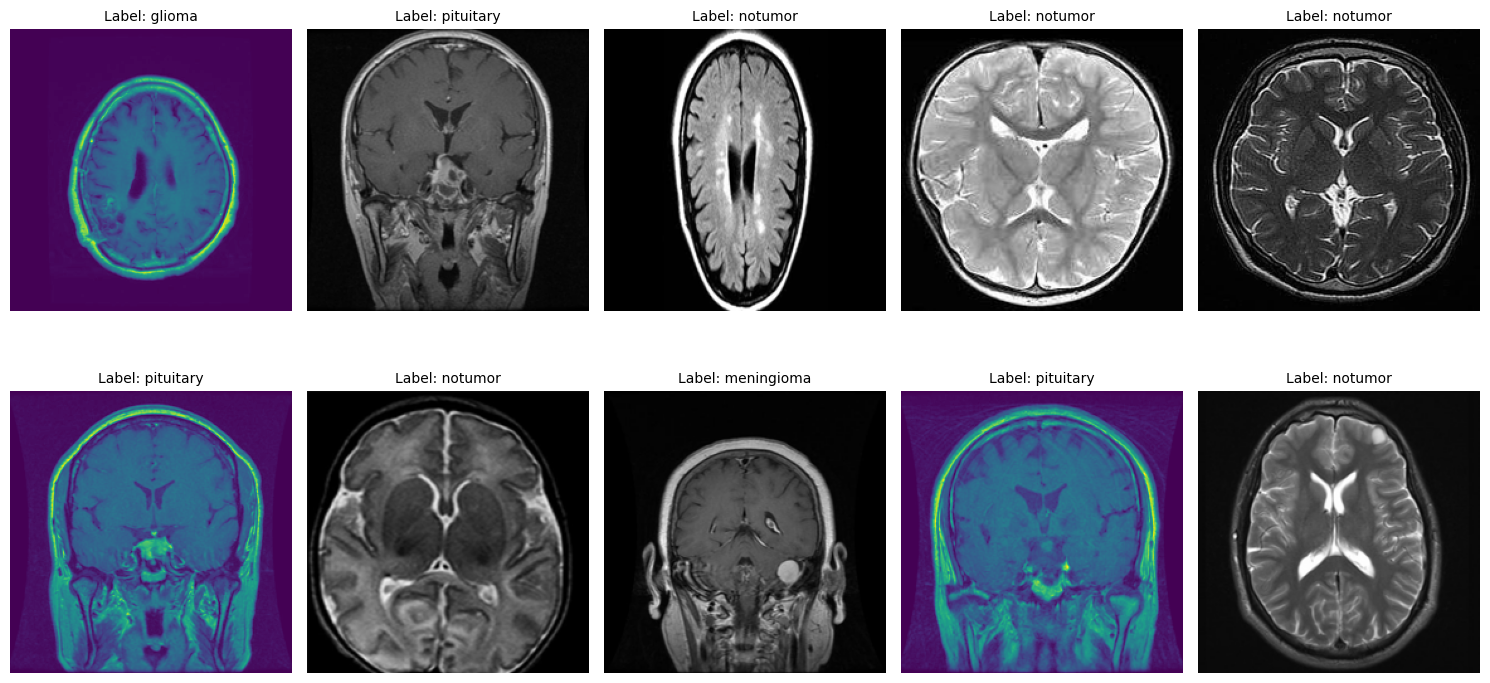

In [11]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()


# Image Preprocessing (Helper Functions)

In [14]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

In [15]:
# Model architecture
IMAGE_SIZE = 128  
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 5

# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)



58889256/58889256 [==============================] - 14s 0us/step
Epoch 1/5


285/285 [==============================] - 367s 1s/step - loss: 0.4688 - sparse_categorical_accuracy: 0.8156
Epoch 2/5
285/285 [==============================] - 338s 1s/step - loss: 0.2441 - sparse_categorical_accuracy: 0.9062
Epoch 3/5
285/285 [==============================] - 348s 1s/step - loss: 0.1689 - sparse_categorical_accuracy: 0.9380
Epoch 4/5
285/285 [==============================] - 330s 1s/step - loss: 0.1199 - sparse_categorical_accuracy: 0.9554
Epoch 5/5
285/285 [==============================] - 332s 1s/step - loss: 0.0915 - sparse_categorical_accuracy: 0.9670


# Train and Val Plots

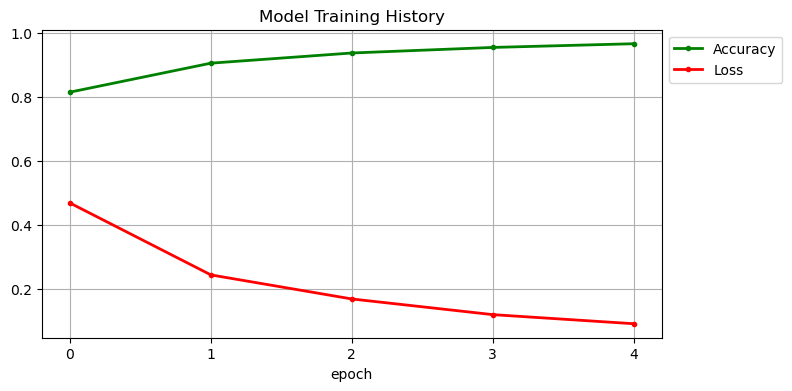

In [16]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# Model Classification Report

In [17]:
!pip install matplotlib sklearn 
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))


Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-pypi-packag

41/41 [==============================] - 44s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.83      0.90       300
           1       0.85      0.99      0.91       306
           2       0.99      0.99      0.99       405
           3       0.98      0.98      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.96      0.95      0.95      1311



# Model Confusion Plot

Confusion Matrix:
[[249  45   3   3]
 [  1 302   1   2]
 [  0   4 401   0]
 [  1   5   1 293]]


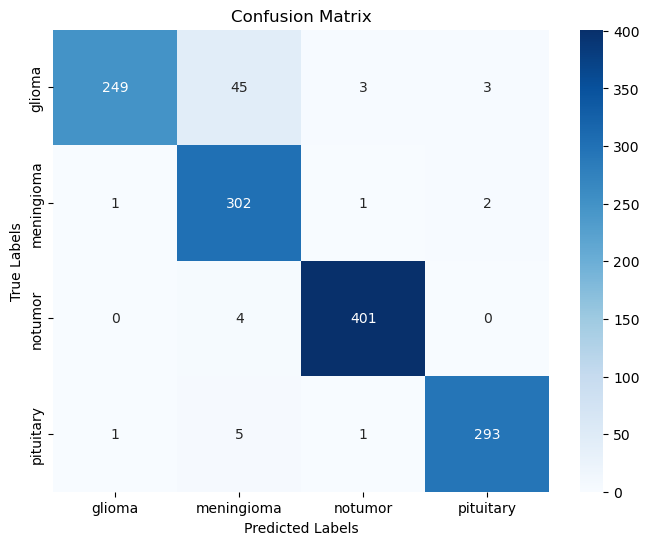

In [18]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Roc Curve Plot


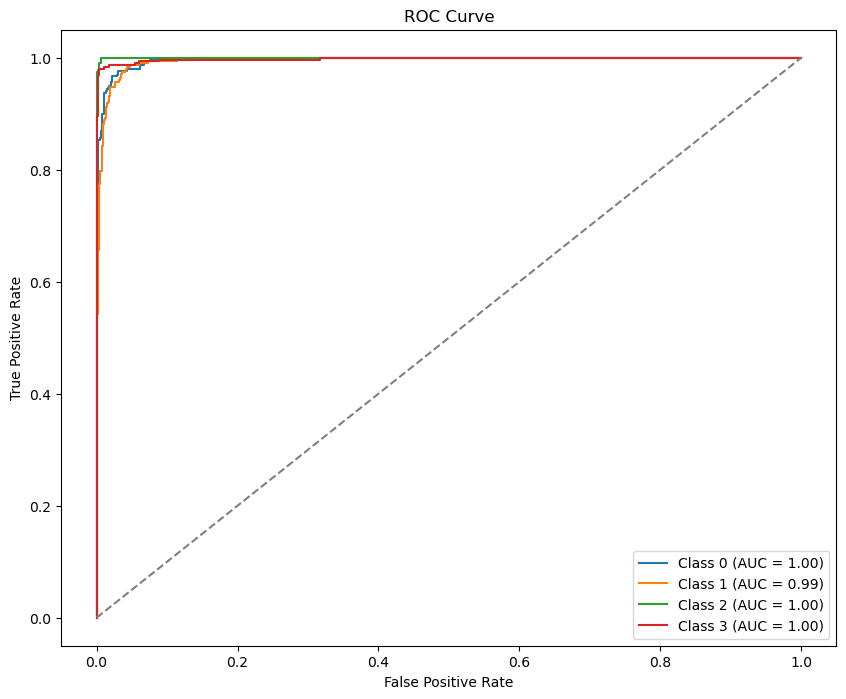

In [19]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Save & Load Model

In [20]:
model.save('model.h5')

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
from tensorflow.keras.models import load_model
model = load_model('model.h5')

# MRI Tumor Detection System

In [22]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))


1/1 [==============================] - 1s 525ms/step


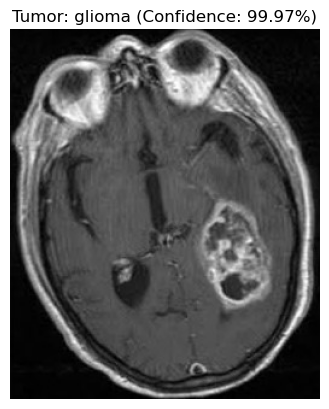

In [25]:
# Example usage
image_path = 'C:/Users/HP/Desktop/ResumeProject/BrainTumor/Te-meTr_0001.jpg' 
detect_and_display(image_path, model)

1/1 [==============================] - 0s 162ms/step


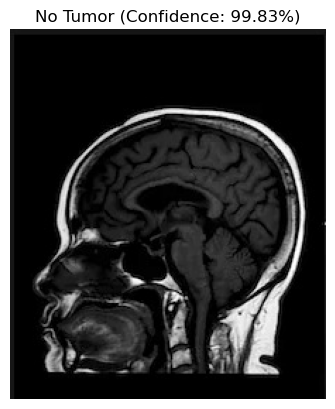

In [ ]:

image_path = 'C:/Users/HP/Desktop/ResumeProject/BrainTumor/Te-noTr_0004.jpg'
detect_and_display(image_path, model)

1/1 [==============================] - 0s 137ms/step


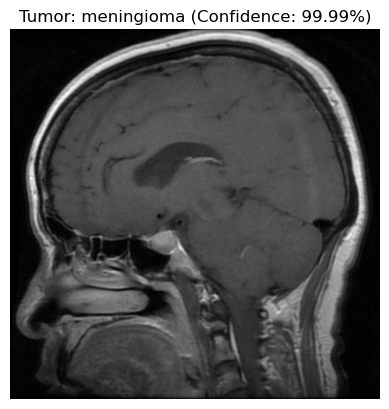

In [28]:

image_path = 'C:/Users/HP/Desktop/ResumeProject/BrainTumor/Te-piTr_0003.jpg'  
detect_and_display(image_path, model)

1/1 [==============================] - 0s 104ms/step


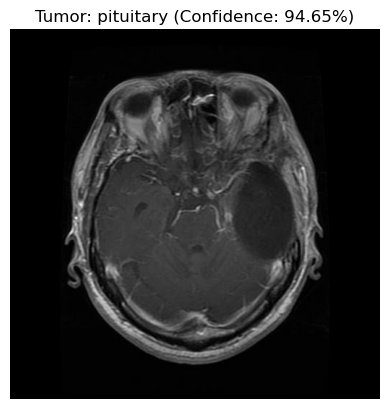

In [29]:
# Example usage
image_path = 'C:/Users/HP/Desktop/ResumeProject/BrainTumor/Te-gl_0015.jpg' 
detect_and_display(image_path, model)